<a href="https://colab.research.google.com/github/ocalzada/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving new-york-city-airbnb-open-data.zip to new-york-city-airbnb-open-data.zip


In [2]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [0]:
import pandas as pd
df = pd.read_csv('AB_NYC_2019.csv')


In [5]:
# baseline mae

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y = df['price']
y_pred = [y.mean()] * len(y)

print('Mean Baseline:')
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))

Mean Baseline:
Mean Absolute Error: 92.45104388371705


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20,
                              random_state=42)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                             random_state=42)

In [0]:
def wrangle(X):
  X = X.copy()
  
  cols_with_zeros = ['number_of_reviews', 'availability_365', 'reviews_per_month']
  for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
        
  # Drop id (always varies, random)
  unusable_variance = ['id', 'name']
  X = X.drop(columns=unusable_variance)
  
  # return the wrangled dataframe
  return X 

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Arrange into X features matrix and y vector target

target = 'price'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [10]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.5MB/s 


In [11]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 72.1919280419223


In [13]:
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MAE: 67.61021298883152


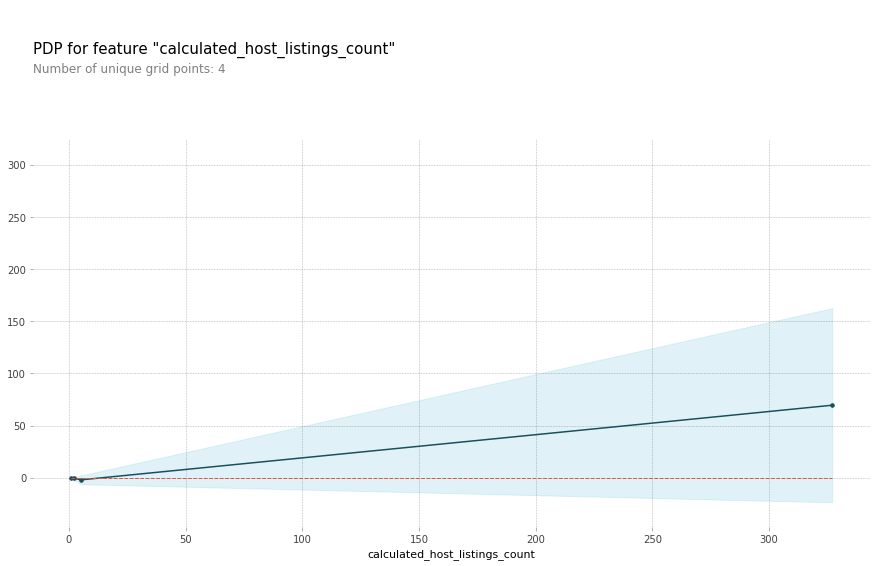

In [19]:
!pip install PDPbox
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'calculated_host_listings_count'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

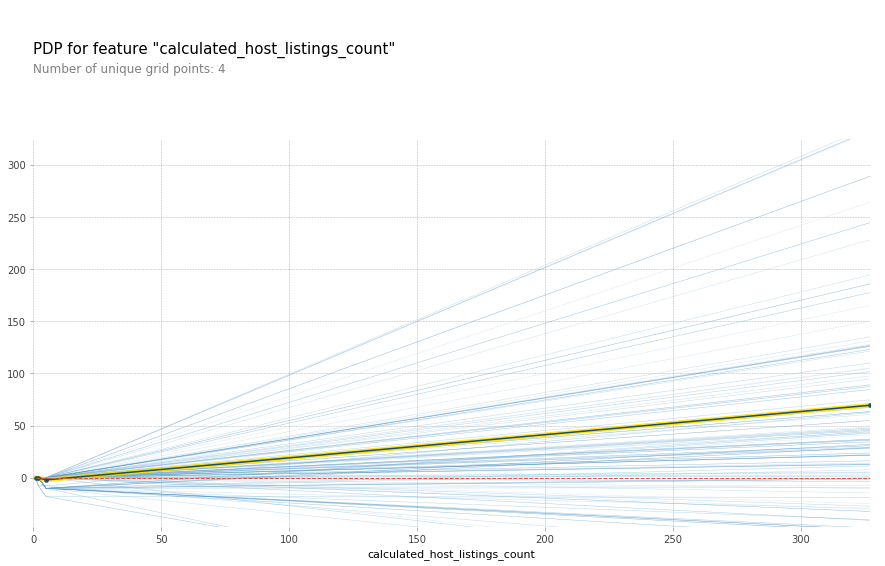

In [25]:
import matplotlib.pyplot as plt
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,327);

In [24]:
df.calculated_host_listings_count.describe()

count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64